In [1]:
%pip install torch 
%pip install torchvision
# %pip install torchsummary
%pip install matplotlib
# %pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [15]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [16]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 256
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

# Other
if torch.cuda.is_available():  
    DEVICE = "cuda:0" 
else:  
    DEVICE = "cpu" 

GRAYSCALE = False

In [17]:
##########################
### CIFAR-10 Dataset
##########################


# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.CIFAR10(root='data', 
                                 train=True, 
                                 transform=transforms.ToTensor(),
                                 download=True)

test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          num_workers=8,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=8,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Files already downloaded and verified


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Image batch dimensions: torch.Size([256, 3, 32, 32])
Image label dimensions: torch.Size([256])
Image batch dimensions: torch.Size([256, 3, 32, 32])
Image label dimensions: torch.Size([256])


MODEL - Replicated original model

In [18]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                           padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) #  Replace the fixed-size average pooling layer with an adaptive average pooling layer that dynamically adjusts to produce a fixed-size output
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet34(num_classes):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

def resnet50(num_classes):
    """Constructs a ResNet-50 model."""
    model = ResNet(block=Bottleneck, 
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

Training & Evaluation

In [29]:
class Trainer:
    def __init__(self, model, train_loader, test_loader, device, num_epochs=10):
        self.model = model.to(device)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  
        self.device = device
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.num_epochs = num_epochs

    def train(self):
        start_time = time.time()
        for epoch in range(self.num_epochs):
            self.model.train()
            for batch_idx, (features, targets) in enumerate(self.train_loader):
                features = features.to(self.device)
                targets = targets.to(self.device)

                # Forward and backprop
                logits, probas = self.model(features)
                cost = F.cross_entropy(logits, targets)
                self.optimizer.zero_grad()
                cost.backward()

                # Update model parameters
                self.optimizer.step()

                # Logging
                if not batch_idx % 150:
                    print('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                          % (epoch+1, self.num_epochs, batch_idx, len(self.train_loader), cost))

            # Evaluation
            self.model.eval()
            with torch.no_grad():
                print('Epoch: %03d/%03d | Train: %.3f%%' % (
                      epoch+1, self.num_epochs, 
                      self.compute_accuracy(self.train_loader)))

            print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    def test(self):
        self.model.eval()
        with torch.no_grad():
            test_start_time = time.time()
            print('Test accuracy: %.2f%%' % (self.compute_accuracy(self.test_loader)))
            print('Time elapsed: %.2f min' % ((time.time() - test_start_time)/60))

    def compute_accuracy(self, data_loader):
        correct_pred, num_examples = 0, 0
        for i, (features, targets) in enumerate(data_loader):

            features = features.to(self.device)
            targets = targets.to(self.device)

            logits, probas = self.model(features)
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100


In [7]:
torch.manual_seed(RANDOM_SEED)
# usage:

model34 = resnet34(NUM_CLASSES)
trainer34 = Trainer(model34, train_loader, test_loader, DEVICE)
trainer34.train()
trainer34.test()


Epoch: 001/010 | Batch 0000/0196 | Cost: 2.6477
Epoch: 001/010 | Batch 0150/0196 | Cost: 1.1902
Epoch: 001/010 | Train: 45.714%
Time elapsed: 0.37 min
Epoch: 002/010 | Batch 0000/0196 | Cost: 1.2077
Epoch: 002/010 | Batch 0150/0196 | Cost: 1.0869
Epoch: 002/010 | Train: 49.254%
Time elapsed: 0.72 min
Epoch: 003/010 | Batch 0000/0196 | Cost: 1.0012
Epoch: 003/010 | Batch 0150/0196 | Cost: 0.9885
Epoch: 003/010 | Train: 58.330%
Time elapsed: 1.08 min
Epoch: 004/010 | Batch 0000/0196 | Cost: 0.8215
Epoch: 004/010 | Batch 0150/0196 | Cost: 0.7444
Epoch: 004/010 | Train: 65.522%
Time elapsed: 1.44 min
Epoch: 005/010 | Batch 0000/0196 | Cost: 0.5850
Epoch: 005/010 | Batch 0150/0196 | Cost: 0.6265
Epoch: 005/010 | Train: 69.244%
Time elapsed: 1.79 min
Epoch: 006/010 | Batch 0000/0196 | Cost: 0.6194
Epoch: 006/010 | Batch 0150/0196 | Cost: 0.5473
Epoch: 006/010 | Train: 76.350%
Time elapsed: 2.16 min
Epoch: 007/010 | Batch 0000/0196 | Cost: 0.4152
Epoch: 007/010 | Batch 0150/0196 | Cost: 0.593

In [8]:
model50 = resnet50(NUM_CLASSES)
trainer50 = Trainer(model50, train_loader, test_loader, DEVICE)
trainer50.train()
trainer50.test()

Epoch: 001/010 | Batch 0000/0196 | Cost: 2.7090
Epoch: 001/010 | Batch 0150/0196 | Cost: 1.5648
Epoch: 001/010 | Train: 27.058%
Time elapsed: 0.68 min
Epoch: 002/010 | Batch 0000/0196 | Cost: 1.8125
Epoch: 002/010 | Batch 0150/0196 | Cost: 1.3268
Epoch: 002/010 | Train: 47.730%
Time elapsed: 1.36 min
Epoch: 003/010 | Batch 0000/0196 | Cost: 1.2131
Epoch: 003/010 | Batch 0150/0196 | Cost: 1.1149
Epoch: 003/010 | Train: 60.642%
Time elapsed: 2.04 min
Epoch: 004/010 | Batch 0000/0196 | Cost: 1.0528
Epoch: 004/010 | Batch 0150/0196 | Cost: 0.9460
Epoch: 004/010 | Train: 61.914%
Time elapsed: 2.72 min
Epoch: 005/010 | Batch 0000/0196 | Cost: 0.8017
Epoch: 005/010 | Batch 0150/0196 | Cost: 1.0518
Epoch: 005/010 | Train: 52.018%
Time elapsed: 3.40 min
Epoch: 006/010 | Batch 0000/0196 | Cost: 1.2836
Epoch: 006/010 | Batch 0150/0196 | Cost: 1.1018
Epoch: 006/010 | Train: 47.736%
Time elapsed: 4.08 min
Epoch: 007/010 | Batch 0000/0196 | Cost: 1.1013
Epoch: 007/010 | Batch 0150/0196 | Cost: 0.915

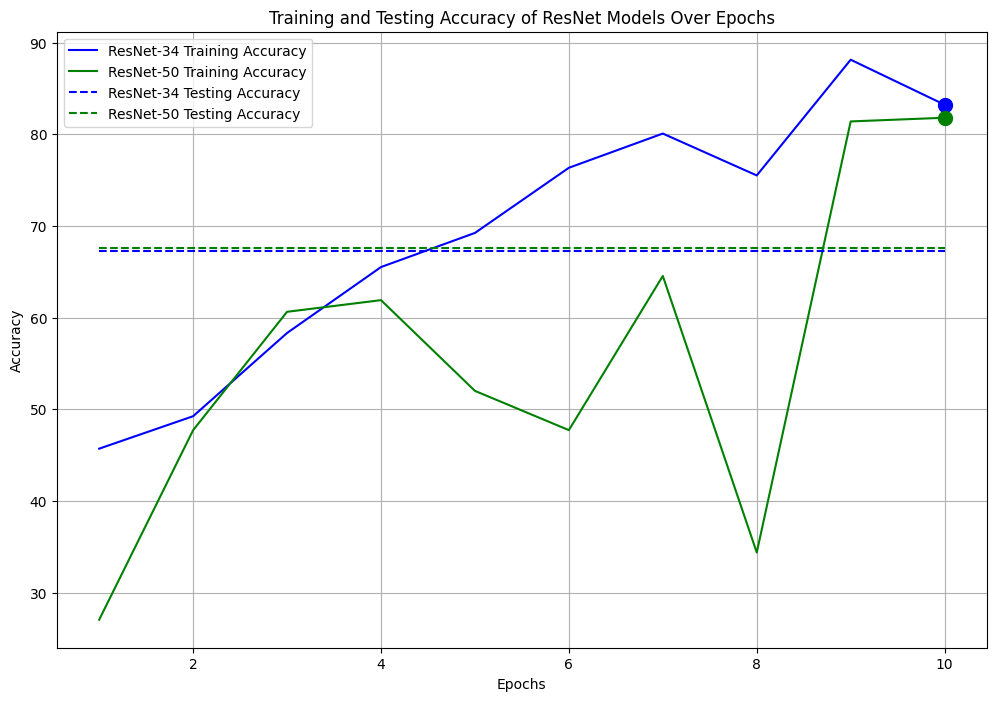

In [7]:
import matplotlib.pyplot as plt

# Example data
epochs = range(1, 11)  # Assuming 20 epochs for simplicity
training_accuracy_resnet34 =  [45.714, 49.254, 58.33, 65.522, 69.244, 76.35, 80.084, 75.514, 88.136, 83.226]
final_testing_accuracy_resnet34 =  67.22
training_accuracy_resnet50 =  [27.058, 47.73, 60.642, 61.914, 52.018, 47.736, 64.552, 34.392, 81.406, 81.808]
final_testing_accuracy_resnet50 = 67.62

plt.figure(figsize=(12, 8))

# Plot training accuracies
plt.plot(epochs, training_accuracy_resnet34, label='ResNet-34 Training Accuracy', color='blue')
plt.plot(epochs, training_accuracy_resnet50, label='ResNet-50 Training Accuracy', color='green')

# Mark final testing accuracies
plt.hlines(final_testing_accuracy_resnet34, epochs[0], epochs[-1], colors='blue', linestyles='dashed', label='ResNet-34 Testing Accuracy')
plt.hlines(final_testing_accuracy_resnet50, epochs[0], epochs[-1], colors='green', linestyles='dashed', label='ResNet-50 Testing Accuracy')

# Highlight the end of training with markers
plt.scatter(epochs[-1], training_accuracy_resnet34[-1], color='blue', s=100, zorder=5)
plt.scatter(epochs[-1], training_accuracy_resnet50[-1], color='green', s=100, zorder=5)

plt.title('Training and Testing Accuracy of ResNet Models Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


MODEL - fully pre-activation

In [9]:
class BasicBlockFullyPre(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlockFullyPre, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = conv3x3(inplanes, planes, stride)
        
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.bn1(x)
        out = self.relu1(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu2(out)
        out = self.conv2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        return out

class BottleneckFullyPre(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BottleneckFullyPre, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        
        self.bn3 = nn.BatchNorm2d(planes)
        self.relu3 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.bn1(x)
        out = self.relu1(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu2(out)
        out = self.conv2(out)

        out = self.bn3(out)
        out = self.relu3(out)
        out = self.conv3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        return out

def resnet34FullyPre(num_classes):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlockFullyPre, 
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

def resnet50FullyPre(num_classes):
    """Constructs a ResNet-50 model."""
    model = ResNet(block=BottleneckFullyPre, 
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [10]:
model34pre_activation = resnet34FullyPre(NUM_CLASSES)
trainer34pre_activation = Trainer(model34pre_activation, train_loader, test_loader, DEVICE)
trainer34pre_activation.train()
trainer34pre_activation.test()

Epoch: 001/010 | Batch 0000/0196 | Cost: 2.5817
Epoch: 001/010 | Batch 0150/0196 | Cost: 1.2852
Epoch: 001/010 | Train: 42.546%
Time elapsed: 0.36 min
Epoch: 002/010 | Batch 0000/0196 | Cost: 1.2553
Epoch: 002/010 | Batch 0150/0196 | Cost: 1.0037
Epoch: 002/010 | Train: 52.416%
Time elapsed: 0.72 min
Epoch: 003/010 | Batch 0000/0196 | Cost: 1.0155
Epoch: 003/010 | Batch 0150/0196 | Cost: 0.9204
Epoch: 003/010 | Train: 58.738%
Time elapsed: 1.08 min
Epoch: 004/010 | Batch 0000/0196 | Cost: 0.7556
Epoch: 004/010 | Batch 0150/0196 | Cost: 0.6287
Epoch: 004/010 | Train: 71.930%
Time elapsed: 1.43 min
Epoch: 005/010 | Batch 0000/0196 | Cost: 0.5671
Epoch: 005/010 | Batch 0150/0196 | Cost: 0.7613
Epoch: 005/010 | Train: 68.394%
Time elapsed: 1.79 min
Epoch: 006/010 | Batch 0000/0196 | Cost: 0.7490
Epoch: 006/010 | Batch 0150/0196 | Cost: 0.6824
Epoch: 006/010 | Train: 81.838%
Time elapsed: 2.15 min
Epoch: 007/010 | Batch 0000/0196 | Cost: 0.4097
Epoch: 007/010 | Batch 0150/0196 | Cost: 0.503

In [11]:
model50pre_activation = resnet50FullyPre(NUM_CLASSES)
trainer50pre_activation = Trainer(model50pre_activation, train_loader, test_loader, DEVICE)
trainer50pre_activation.train()
trainer50pre_activation.test()

Epoch: 001/010 | Batch 0000/0196 | Cost: 2.6231
Epoch: 001/010 | Batch 0150/0196 | Cost: 1.3604
Epoch: 001/010 | Train: 53.206%
Time elapsed: 0.68 min
Epoch: 002/010 | Batch 0000/0196 | Cost: 1.1396
Epoch: 002/010 | Batch 0150/0196 | Cost: 1.0501
Epoch: 002/010 | Train: 62.334%
Time elapsed: 1.36 min
Epoch: 003/010 | Batch 0000/0196 | Cost: 0.7246
Epoch: 003/010 | Batch 0150/0196 | Cost: 0.8131
Epoch: 003/010 | Train: 75.242%
Time elapsed: 2.04 min
Epoch: 004/010 | Batch 0000/0196 | Cost: 0.5925
Epoch: 004/010 | Batch 0150/0196 | Cost: 0.6671
Epoch: 004/010 | Train: 70.224%
Time elapsed: 2.72 min
Epoch: 005/010 | Batch 0000/0196 | Cost: 0.6040
Epoch: 005/010 | Batch 0150/0196 | Cost: 0.6057
Epoch: 005/010 | Train: 75.762%
Time elapsed: 3.41 min
Epoch: 006/010 | Batch 0000/0196 | Cost: 0.5246
Epoch: 006/010 | Batch 0150/0196 | Cost: 0.4440
Epoch: 006/010 | Train: 83.226%
Time elapsed: 4.09 min
Epoch: 007/010 | Batch 0000/0196 | Cost: 0.3638
Epoch: 007/010 | Batch 0150/0196 | Cost: 0.426

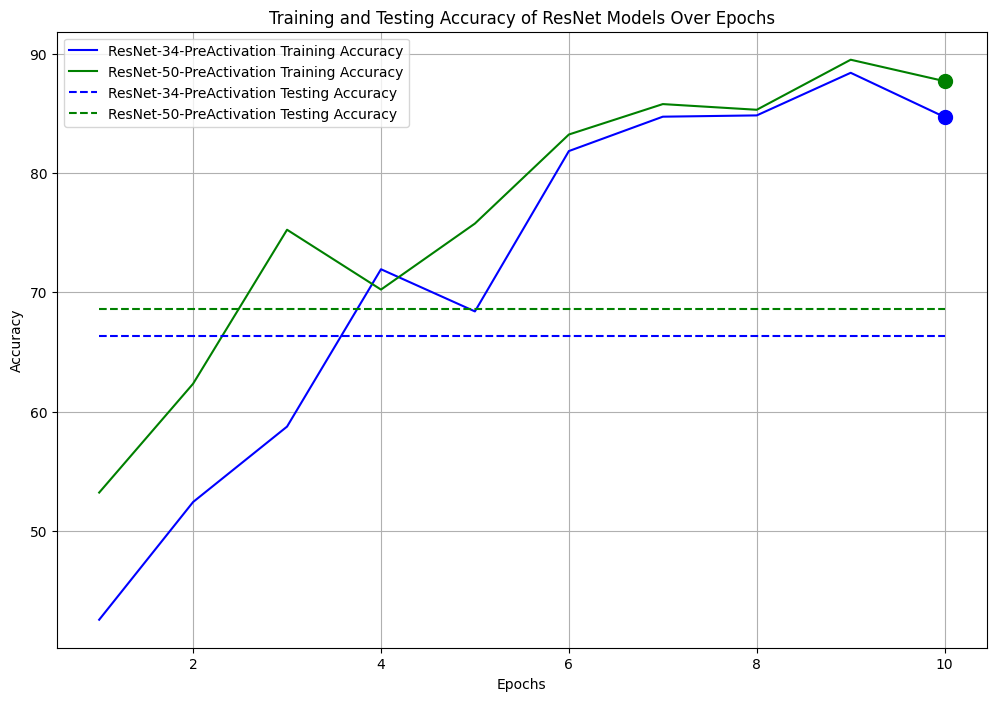

In [8]:
import matplotlib.pyplot as plt

# Example data
epochs = range(1, 11)  # Assuming 20 epochs for simplicity
training_accuracy_resnet34 = [
    42.546,  # Epoch 1
    52.416,  # Epoch 2
    58.738,  # Epoch 3
    71.930,  # Epoch 4
    68.394,  # Epoch 5
    81.838,  # Epoch 6
    84.720,  # Epoch 7
    84.828,  # Epoch 8
    88.400,  # Epoch 9
    84.690   # Epoch 10
]

# Training accuracy data for ResNet-50
training_accuracy_resnet50 = [
    53.206,  # Epoch 1
    62.334,  # Epoch 2
    75.242,  # Epoch 3
    70.224,  # Epoch 4
    75.762,  # Epoch 5
    83.226,  # Epoch 6
    85.776,  # Epoch 7
    85.300,  # Epoch 8
    89.496,  # Epoch 9
    87.698   # Epoch 10
]

# Final testing accuracy for ResNet-34
final_testing_accuracy_resnet34 = 66.33

# Final testing accuracy for ResNet-50
final_testing_accuracy_resnet50 = 68.60

plt.figure(figsize=(12, 8))

# Plot training accuracies
plt.plot(epochs, training_accuracy_resnet34, label='ResNet-34-PreActivation Training Accuracy', color='blue')
plt.plot(epochs, training_accuracy_resnet50, label='ResNet-50-PreActivation Training Accuracy', color='green')

# Mark final testing accuracies
plt.hlines(final_testing_accuracy_resnet34, epochs[0], epochs[-1], colors='blue', linestyles='dashed', label='ResNet-34-PreActivation Testing Accuracy')
plt.hlines(final_testing_accuracy_resnet50, epochs[0], epochs[-1], colors='green', linestyles='dashed', label='ResNet-50-PreActivation Testing Accuracy')

# Highlight the end of training with markers
plt.scatter(epochs[-1], training_accuracy_resnet34[-1], color='blue', s=100, zorder=5)
plt.scatter(epochs[-1], training_accuracy_resnet50[-1], color='green', s=100, zorder=5)

plt.title('Training and Testing Accuracy of ResNet Models Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


MODEL - Without Average pool

In [12]:
class ResNet_noAvgPool(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet_noAvgPool, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) 

        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

def resnet34_noAvgPool(num_classes):
    """Constructs a ResNet-34 model."""
    model = ResNet_noAvgPool(block=BasicBlock, 
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

def resnet50_noAvgPool(num_classes):
    """Constructs a ResNet-50 model."""
    model = ResNet_noAvgPool(block=Bottleneck, 
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [13]:
model34_noAvgPool = resnet34_noAvgPool(NUM_CLASSES)
trainer34_noAvgPool = Trainer(model34_noAvgPool, train_loader, test_loader, DEVICE)
trainer34_noAvgPool.train()
trainer34_noAvgPool.test()

Epoch: 001/010 | Batch 0000/0196 | Cost: 2.5781
Epoch: 001/010 | Batch 0150/0196 | Cost: 1.2427
Epoch: 001/010 | Train: 51.278%
Time elapsed: 0.36 min
Epoch: 002/010 | Batch 0000/0196 | Cost: 1.1159
Epoch: 002/010 | Batch 0150/0196 | Cost: 0.9278
Epoch: 002/010 | Train: 49.024%
Time elapsed: 0.72 min
Epoch: 003/010 | Batch 0000/0196 | Cost: 0.8390
Epoch: 003/010 | Batch 0150/0196 | Cost: 0.7541
Epoch: 003/010 | Train: 62.140%
Time elapsed: 1.09 min
Epoch: 004/010 | Batch 0000/0196 | Cost: 0.6692
Epoch: 004/010 | Batch 0150/0196 | Cost: 0.6997
Epoch: 004/010 | Train: 70.344%
Time elapsed: 1.45 min
Epoch: 005/010 | Batch 0000/0196 | Cost: 0.6161
Epoch: 005/010 | Batch 0150/0196 | Cost: 0.6936
Epoch: 005/010 | Train: 73.920%
Time elapsed: 1.81 min
Epoch: 006/010 | Batch 0000/0196 | Cost: 0.4578
Epoch: 006/010 | Batch 0150/0196 | Cost: 0.5958
Epoch: 006/010 | Train: 77.340%
Time elapsed: 2.17 min
Epoch: 007/010 | Batch 0000/0196 | Cost: 0.4792
Epoch: 007/010 | Batch 0150/0196 | Cost: 0.553

In [14]:
model50_noAvgPool = resnet50_noAvgPool(NUM_CLASSES)
trainer50_noAvgPool = Trainer(model50_noAvgPool, train_loader, test_loader, DEVICE)
trainer50_noAvgPool.train()
trainer50_noAvgPool.test()

Epoch: 001/010 | Batch 0000/0196 | Cost: 2.6548
Epoch: 001/010 | Batch 0150/0196 | Cost: 1.5716
Epoch: 001/010 | Train: 45.654%
Time elapsed: 0.68 min
Epoch: 002/010 | Batch 0000/0196 | Cost: 1.5528
Epoch: 002/010 | Batch 0150/0196 | Cost: 2.0986
Epoch: 002/010 | Train: 44.664%
Time elapsed: 1.37 min
Epoch: 003/010 | Batch 0000/0196 | Cost: 1.5536
Epoch: 003/010 | Batch 0150/0196 | Cost: 1.5897
Epoch: 003/010 | Train: 55.306%
Time elapsed: 2.05 min
Epoch: 004/010 | Batch 0000/0196 | Cost: 1.1270
Epoch: 004/010 | Batch 0150/0196 | Cost: 1.2867
Epoch: 004/010 | Train: 59.368%
Time elapsed: 2.74 min
Epoch: 005/010 | Batch 0000/0196 | Cost: 1.0115
Epoch: 005/010 | Batch 0150/0196 | Cost: 1.0306
Epoch: 005/010 | Train: 61.588%
Time elapsed: 3.42 min
Epoch: 006/010 | Batch 0000/0196 | Cost: 0.8887
Epoch: 006/010 | Batch 0150/0196 | Cost: 1.1074
Epoch: 006/010 | Train: 68.294%
Time elapsed: 4.11 min
Epoch: 007/010 | Batch 0000/0196 | Cost: 0.8553
Epoch: 007/010 | Batch 0150/0196 | Cost: 1.201

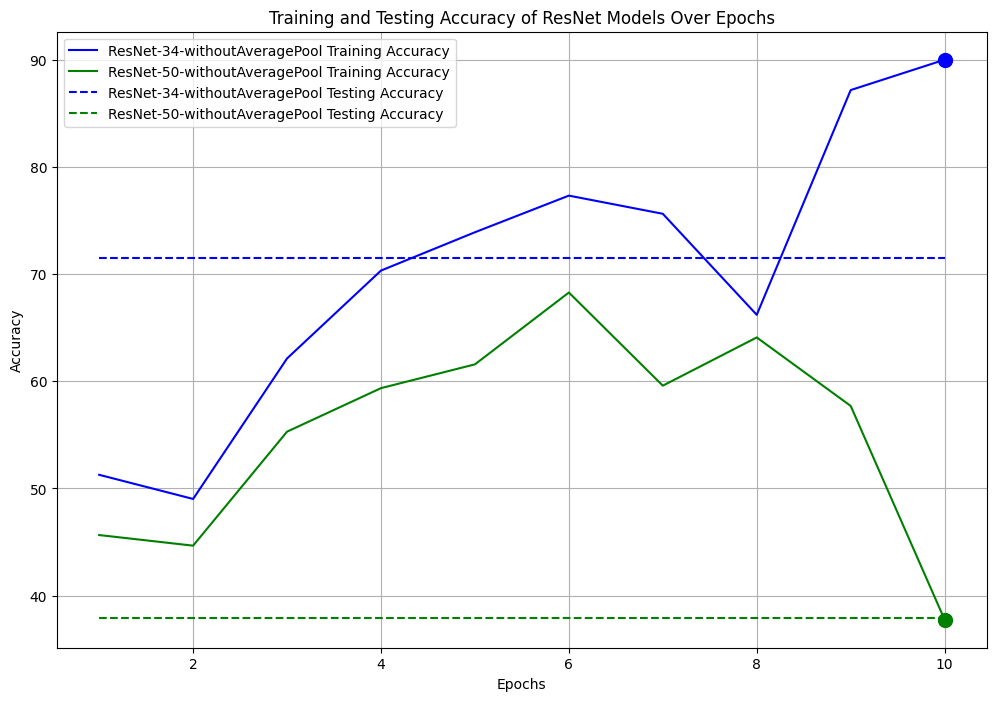

In [3]:
import matplotlib.pyplot as plt

# Example data
epochs = range(1, 11)  # Assuming 20 epochs for simplicity
training_accuracy_resnet34 = [51.278, 49.024, 62.14, 70.344, 73.92, 77.34, 75.644, 66.212, 87.192, 90.026]
# Training accuracy data for ResNet-50
training_accuracy_resnet50 = [45.654, 44.664, 55.306, 59.368, 61.588, 68.294, 59.598, 64.1, 57.708, 37.75]

# Final testing accuracy for ResNet-34
final_testing_accuracy_resnet34 = 71.55

# Final testing accuracy for ResNet-50
final_testing_accuracy_resnet50 = 37.92

plt.figure(figsize=(12, 8))

# Plot training accuracies
plt.plot(epochs, training_accuracy_resnet34, label='ResNet-34-withoutAveragePool Training Accuracy', color='blue')
plt.plot(epochs, training_accuracy_resnet50, label='ResNet-50-withoutAveragePool Training Accuracy', color='green')

# Mark final testing accuracies
plt.hlines(final_testing_accuracy_resnet34, epochs[0], epochs[-1], colors='blue', linestyles='dashed', label='ResNet-34-withoutAveragePool Testing Accuracy')
plt.hlines(final_testing_accuracy_resnet50, epochs[0], epochs[-1], colors='green', linestyles='dashed', label='ResNet-50-withoutAveragePool Testing Accuracy')

# Highlight the end of training with markers
plt.scatter(epochs[-1], training_accuracy_resnet34[-1], color='blue', s=100, zorder=5)
plt.scatter(epochs[-1], training_accuracy_resnet50[-1], color='green', s=100, zorder=5)

plt.title('Training and Testing Accuracy of ResNet Models Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


MODEL - change ReLu in residual block

In [17]:
class BasicBlock_leakyReLu(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock_leakyReLu, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck_leakyReLu(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck_leakyReLu, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                           padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

def resnet34_leakyReLu(num_classes):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock_leakyReLu, 
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

def resnet50_leakyReLu(num_classes):
    """Constructs a ResNet-50 model."""
    model = ResNet(block=Bottleneck_leakyReLu, 
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [18]:
model34_leakyReLu = resnet34_leakyReLu(NUM_CLASSES)
trainer34_leakyReLu = Trainer(model34_leakyReLu, train_loader, test_loader, DEVICE)
trainer34_leakyReLu.train()
trainer34_leakyReLu.test()

Epoch: 001/010 | Batch 0000/0196 | Cost: 2.5708
Epoch: 001/010 | Batch 0150/0196 | Cost: 1.2424
Epoch: 001/010 | Train: 43.526%
Time elapsed: 0.36 min
Epoch: 002/010 | Batch 0000/0196 | Cost: 1.2814
Epoch: 002/010 | Batch 0150/0196 | Cost: 1.0783
Epoch: 002/010 | Train: 50.054%
Time elapsed: 0.72 min
Epoch: 003/010 | Batch 0000/0196 | Cost: 0.9055
Epoch: 003/010 | Batch 0150/0196 | Cost: 0.8045
Epoch: 003/010 | Train: 51.108%
Time elapsed: 1.08 min
Epoch: 004/010 | Batch 0000/0196 | Cost: 0.7564
Epoch: 004/010 | Batch 0150/0196 | Cost: 0.6692
Epoch: 004/010 | Train: 72.336%
Time elapsed: 1.45 min
Epoch: 005/010 | Batch 0000/0196 | Cost: 0.6959
Epoch: 005/010 | Batch 0150/0196 | Cost: 0.6581
Epoch: 005/010 | Train: 74.142%
Time elapsed: 1.81 min
Epoch: 006/010 | Batch 0000/0196 | Cost: 0.5266
Epoch: 006/010 | Batch 0150/0196 | Cost: 0.5856
Epoch: 006/010 | Train: 79.030%
Time elapsed: 2.17 min
Epoch: 007/010 | Batch 0000/0196 | Cost: 0.3888
Epoch: 007/010 | Batch 0150/0196 | Cost: 0.472

In [19]:
model50_leakyReLu = resnet50_leakyReLu(NUM_CLASSES)
trainer50_leakyReLu = Trainer(model50_leakyReLu, train_loader, test_loader, DEVICE)
trainer50_leakyReLu.train()
trainer50_leakyReLu.test()

Epoch: 001/010 | Batch 0000/0196 | Cost: 2.6090
Epoch: 001/010 | Batch 0150/0196 | Cost: 1.5377
Epoch: 001/010 | Train: 47.198%
Time elapsed: 0.69 min
Epoch: 002/010 | Batch 0000/0196 | Cost: 1.3062
Epoch: 002/010 | Batch 0150/0196 | Cost: 1.2738
Epoch: 002/010 | Train: 55.824%
Time elapsed: 1.38 min
Epoch: 003/010 | Batch 0000/0196 | Cost: 1.2904
Epoch: 003/010 | Batch 0150/0196 | Cost: 1.0312
Epoch: 003/010 | Train: 42.752%
Time elapsed: 2.07 min
Epoch: 004/010 | Batch 0000/0196 | Cost: 1.1504
Epoch: 004/010 | Batch 0150/0196 | Cost: 0.9995
Epoch: 004/010 | Train: 60.832%
Time elapsed: 2.76 min
Epoch: 005/010 | Batch 0000/0196 | Cost: 0.7800
Epoch: 005/010 | Batch 0150/0196 | Cost: 1.0013
Epoch: 005/010 | Train: 56.194%
Time elapsed: 3.46 min
Epoch: 006/010 | Batch 0000/0196 | Cost: 0.8521
Epoch: 006/010 | Batch 0150/0196 | Cost: 0.8065
Epoch: 006/010 | Train: 40.188%
Time elapsed: 4.15 min
Epoch: 007/010 | Batch 0000/0196 | Cost: 1.4334
Epoch: 007/010 | Batch 0150/0196 | Cost: 1.822

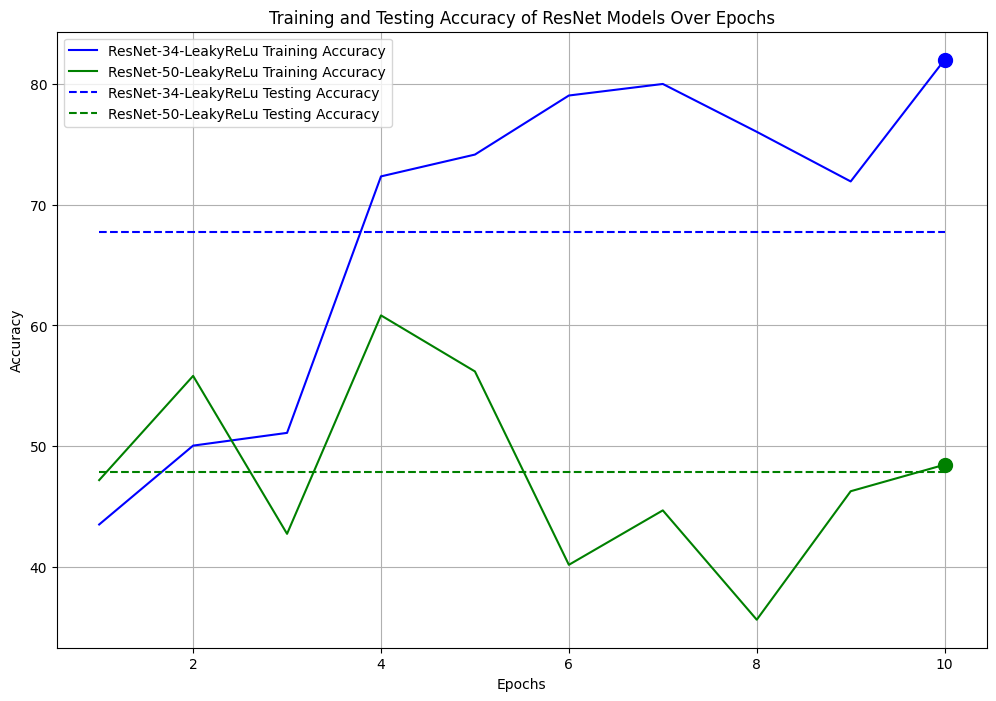

In [11]:
import matplotlib.pyplot as plt

# Example data
epochs = range(1, 11)  # Assuming 20 epochs for simplicity
training_accuracy_resnet34= [43.526, 50.054, 51.108, 72.336, 74.142, 79.03, 79.986, 76.026, 71.918, 81.992]
final_testing_accuracy_resnet34= 67.72
training_accuracy_resnet50= [47.198, 55.824, 42.752, 60.832, 56.194, 40.188, 44.694, 35.644, 46.278, 48.474]
final_testing_accuracy_resnet50= 47.89

plt.figure(figsize=(12, 8))

# Plot training accuracies
plt.plot(epochs, training_accuracy_resnet34, label='ResNet-34-LeakyReLu Training Accuracy', color='blue')
plt.plot(epochs, training_accuracy_resnet50, label='ResNet-50-LeakyReLu Training Accuracy', color='green')

# Mark final testing accuracies
plt.hlines(final_testing_accuracy_resnet34, epochs[0], epochs[-1], colors='blue', linestyles='dashed', label='ResNet-34-LeakyReLu Testing Accuracy')
plt.hlines(final_testing_accuracy_resnet50, epochs[0], epochs[-1], colors='green', linestyles='dashed', label='ResNet-50-LeakyReLu Testing Accuracy')

# Highlight the end of training with markers
plt.scatter(epochs[-1], training_accuracy_resnet34[-1], color='blue', s=100, zorder=5)
plt.scatter(epochs[-1], training_accuracy_resnet50[-1], color='green', s=100, zorder=5)

plt.title('Training and Testing Accuracy of ResNet Models Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
class BasicBlock_PReLu(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock_PReLu, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.PReLU()
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck_PReLu(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck_PReLu, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                           padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.PReLU()
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

def resnet34_PReLu(num_classes):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock_PReLu, 
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

def resnet50_PReLu(num_classes):
    """Constructs a ResNet-50 model."""
    model = ResNet(block=Bottleneck_PReLu, 
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [21]:
model34_PReLu = resnet34_PReLu(NUM_CLASSES)
trainer34_PReLu = Trainer(model34_PReLu, train_loader, test_loader, DEVICE)
trainer34_PReLu.train()
trainer34_PReLu.test()

Epoch: 001/010 | Batch 0000/0196 | Cost: 2.6473
Epoch: 001/010 | Batch 0150/0196 | Cost: 1.2140
Epoch: 001/010 | Train: 50.036%
Time elapsed: 0.37 min
Epoch: 002/010 | Batch 0000/0196 | Cost: 1.0580
Epoch: 002/010 | Batch 0150/0196 | Cost: 1.0077
Epoch: 002/010 | Train: 56.404%
Time elapsed: 0.74 min
Epoch: 003/010 | Batch 0000/0196 | Cost: 0.7653
Epoch: 003/010 | Batch 0150/0196 | Cost: 0.9043
Epoch: 003/010 | Train: 59.516%
Time elapsed: 1.11 min
Epoch: 004/010 | Batch 0000/0196 | Cost: 0.6591
Epoch: 004/010 | Batch 0150/0196 | Cost: 0.6272
Epoch: 004/010 | Train: 72.252%
Time elapsed: 1.47 min
Epoch: 005/010 | Batch 0000/0196 | Cost: 0.5811
Epoch: 005/010 | Batch 0150/0196 | Cost: 0.6138
Epoch: 005/010 | Train: 77.766%
Time elapsed: 1.84 min
Epoch: 006/010 | Batch 0000/0196 | Cost: 0.4511
Epoch: 006/010 | Batch 0150/0196 | Cost: 0.4246
Epoch: 006/010 | Train: 68.510%
Time elapsed: 2.21 min
Epoch: 007/010 | Batch 0000/0196 | Cost: 0.3017
Epoch: 007/010 | Batch 0150/0196 | Cost: 0.369

In [22]:
model50_PReLu = resnet50_PReLu(NUM_CLASSES)
trainer50_PReLu = Trainer(model50_PReLu, train_loader, test_loader, DEVICE)
trainer50_PReLu.train()
trainer50_PReLu.test()

Epoch: 001/010 | Batch 0000/0196 | Cost: 2.5988
Epoch: 001/010 | Batch 0150/0196 | Cost: 1.2469
Epoch: 001/010 | Train: 57.516%
Time elapsed: 0.70 min
Epoch: 002/010 | Batch 0000/0196 | Cost: 1.0791
Epoch: 002/010 | Batch 0150/0196 | Cost: 0.9652
Epoch: 002/010 | Train: 66.906%
Time elapsed: 1.40 min
Epoch: 003/010 | Batch 0000/0196 | Cost: 1.0809
Epoch: 003/010 | Batch 0150/0196 | Cost: 0.9959
Epoch: 003/010 | Train: 43.244%
Time elapsed: 2.10 min
Epoch: 004/010 | Batch 0000/0196 | Cost: 1.1495
Epoch: 004/010 | Batch 0150/0196 | Cost: 1.0853
Epoch: 004/010 | Train: 42.010%
Time elapsed: 2.80 min
Epoch: 005/010 | Batch 0000/0196 | Cost: 1.4117
Epoch: 005/010 | Batch 0150/0196 | Cost: 1.0441
Epoch: 005/010 | Train: 67.054%
Time elapsed: 3.50 min
Epoch: 006/010 | Batch 0000/0196 | Cost: 0.8551
Epoch: 006/010 | Batch 0150/0196 | Cost: 0.8927
Epoch: 006/010 | Train: 74.082%
Time elapsed: 4.20 min
Epoch: 007/010 | Batch 0000/0196 | Cost: 0.6309
Epoch: 007/010 | Batch 0150/0196 | Cost: 0.733

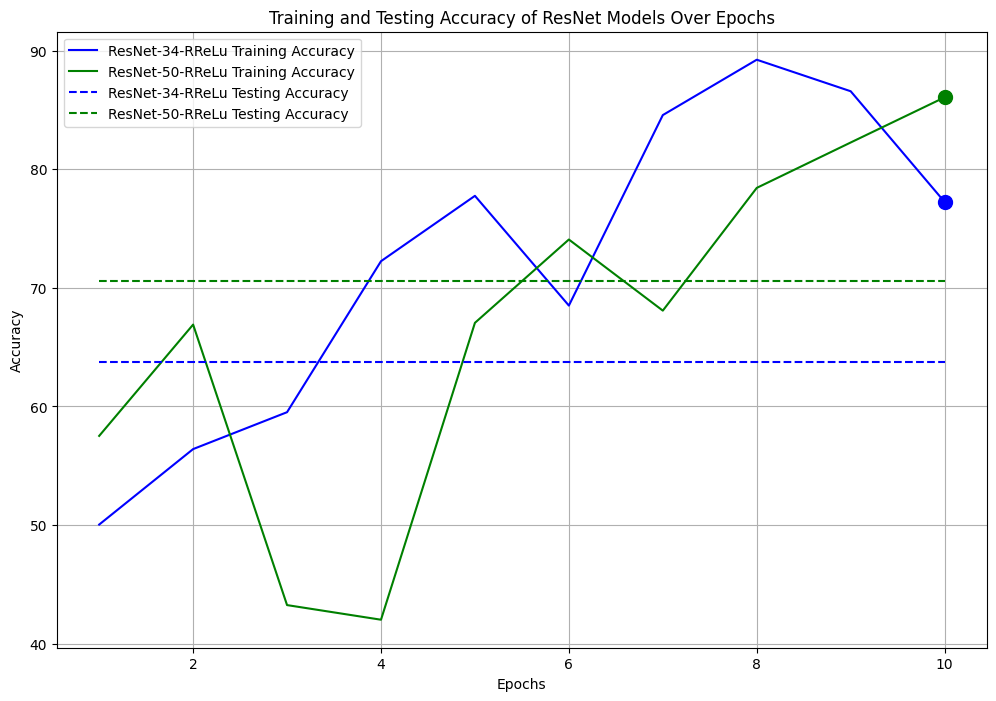

In [13]:
import matplotlib.pyplot as plt

# Example data
training_accuracy_resnet34= [50.036, 56.404, 59.516, 72.252, 77.766, 68.51, 84.578, 89.248, 86.588, 77.248]
final_testing_accuracy_resnet34= 63.75
training_accuracy_resnet50= [57.516, 66.906, 43.244, 42.01, 67.054, 74.082, 68.084, 78.436, 82.266, 86.076]
final_testing_accuracy_resnet50= 70.55

plt.figure(figsize=(12, 8))

# Plot training accuracies
plt.plot(epochs, training_accuracy_resnet34, label='ResNet-34-RReLu Training Accuracy', color='blue')
plt.plot(epochs, training_accuracy_resnet50, label='ResNet-50-RReLu Training Accuracy', color='green')

# Mark final testing accuracies
plt.hlines(final_testing_accuracy_resnet34, epochs[0], epochs[-1], colors='blue', linestyles='dashed', label='ResNet-34-RReLu Testing Accuracy')
plt.hlines(final_testing_accuracy_resnet50, epochs[0], epochs[-1], colors='green', linestyles='dashed', label='ResNet-50-RReLu Testing Accuracy')

# Highlight the end of training with markers
plt.scatter(epochs[-1], training_accuracy_resnet34[-1], color='blue', s=100, zorder=5)
plt.scatter(epochs[-1], training_accuracy_resnet50[-1], color='green', s=100, zorder=5)

plt.title('Training and Testing Accuracy of ResNet Models Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Adding Width

In [27]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale, width_multiplier=1):
        self.inplanes = 64 * width_multiplier  # Adjust initial number of planes
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64 * width_multiplier, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64 * width_multiplier)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64 * width_multiplier, layers[0])
        self.layer2 = self._make_layer(block, 128 * width_multiplier, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256 * width_multiplier, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512 * width_multiplier, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion * width_multiplier, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas
    
def resnet34Width(num_classes):
    model = ResNet(block=BasicBlock, 
               layers=[3, 4, 6, 3],
               num_classes=NUM_CLASSES,
               grayscale=GRAYSCALE,
               width_multiplier=2)
    return model

def resnet50Width(num_classes):
    model = ResNet(block=Bottleneck, 
               layers=[3, 4, 6, 3],
               num_classes=NUM_CLASSES,
               grayscale=GRAYSCALE,
               width_multiplier=2)
    return model

In [30]:
torch.manual_seed(RANDOM_SEED)

model34_width = resnet34Width(NUM_CLASSES)
trainer34_width = Trainer(model34_width, train_loader, test_loader, DEVICE)
trainer34_width.train()
trainer34_width.test()

Epoch: 001/010 | Batch 0000/0196 | Cost: 2.6616
Epoch: 001/010 | Batch 0150/0196 | Cost: 1.2771
Epoch: 001/010 | Train: 36.112%
Time elapsed: 1.22 min
Epoch: 002/010 | Batch 0000/0196 | Cost: 1.1989
Epoch: 002/010 | Batch 0150/0196 | Cost: 0.9944
Epoch: 002/010 | Train: 55.202%
Time elapsed: 2.44 min
Epoch: 003/010 | Batch 0000/0196 | Cost: 0.8036
Epoch: 003/010 | Batch 0150/0196 | Cost: 0.9508
Epoch: 003/010 | Train: 71.828%
Time elapsed: 3.66 min
Epoch: 004/010 | Batch 0000/0196 | Cost: 0.6284
Epoch: 004/010 | Batch 0150/0196 | Cost: 0.6617
Epoch: 004/010 | Train: 75.898%
Time elapsed: 4.88 min
Epoch: 005/010 | Batch 0000/0196 | Cost: 0.5831
Epoch: 005/010 | Batch 0150/0196 | Cost: 0.6551
Epoch: 005/010 | Train: 69.020%
Time elapsed: 6.10 min
Epoch: 006/010 | Batch 0000/0196 | Cost: 0.4564
Epoch: 006/010 | Batch 0150/0196 | Cost: 0.5097
Epoch: 006/010 | Train: 80.640%
Time elapsed: 7.32 min
Epoch: 007/010 | Batch 0000/0196 | Cost: 0.3982
Epoch: 007/010 | Batch 0150/0196 | Cost: 0.463

In [31]:
model50_width = resnet50Width(NUM_CLASSES)
trainer50_width = Trainer(model50_width, train_loader, test_loader, DEVICE)
trainer50_width.train()
trainer50_width.test()

Epoch: 001/010 | Batch 0000/0196 | Cost: 2.8206
Epoch: 001/010 | Batch 0150/0196 | Cost: 1.3094
Epoch: 001/010 | Train: 51.760%
Time elapsed: 2.51 min
Epoch: 002/010 | Batch 0000/0196 | Cost: 1.4386
Epoch: 002/010 | Batch 0150/0196 | Cost: 1.8599
Epoch: 002/010 | Train: 33.846%
Time elapsed: 5.03 min
Epoch: 003/010 | Batch 0000/0196 | Cost: 1.3424
Epoch: 003/010 | Batch 0150/0196 | Cost: 1.7310
Epoch: 003/010 | Train: 44.802%
Time elapsed: 7.54 min
Epoch: 004/010 | Batch 0000/0196 | Cost: 1.5647
Epoch: 004/010 | Batch 0150/0196 | Cost: 1.4024
Epoch: 004/010 | Train: 48.650%
Time elapsed: 10.06 min
Epoch: 005/010 | Batch 0000/0196 | Cost: 1.7421
Epoch: 005/010 | Batch 0150/0196 | Cost: 1.0759
Epoch: 005/010 | Train: 61.400%
Time elapsed: 12.58 min
Epoch: 006/010 | Batch 0000/0196 | Cost: 1.2562
Epoch: 006/010 | Batch 0150/0196 | Cost: 1.0222
Epoch: 006/010 | Train: 51.886%
Time elapsed: 15.10 min
Epoch: 007/010 | Batch 0000/0196 | Cost: 0.8483
Epoch: 007/010 | Batch 0150/0196 | Cost: 1.

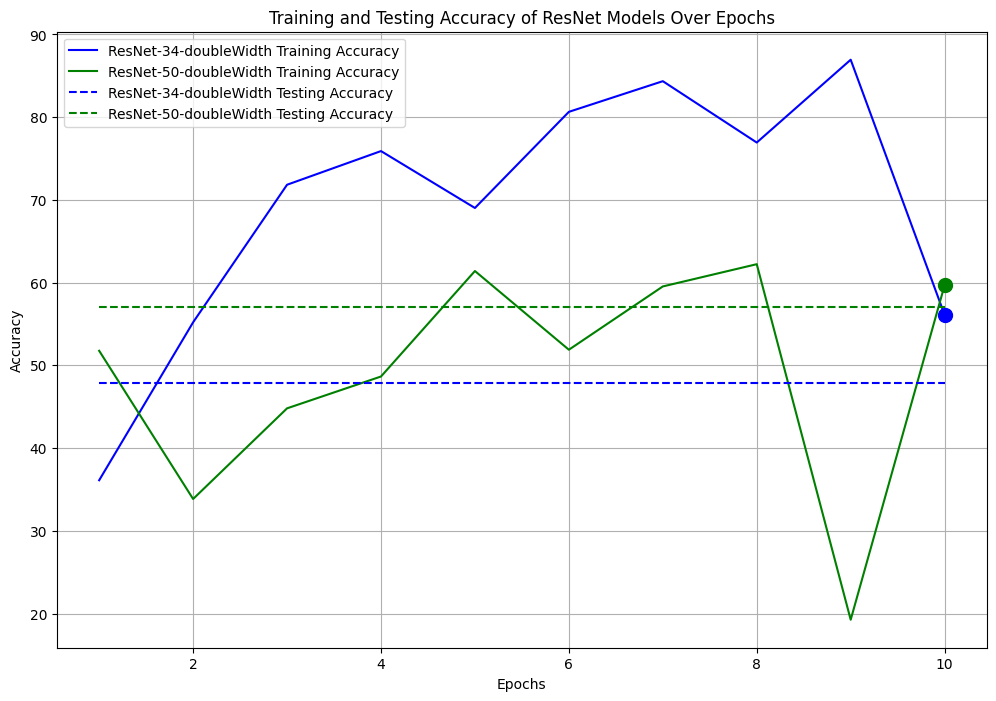

In [33]:
import matplotlib.pyplot as plt

# Example data
training_accuracy_resnet34= [36.112, 55.202, 71.828, 75.898, 69.02, 80.64, 84.346, 76.93, 86.94, 56.092]
final_testing_accuracy_resnet34= 47.91
training_accuracy_resnet50= [51.76, 33.846, 44.802, 48.65, 61.4, 51.886, 59.536, 62.226, 19.252, 59.698]
final_testing_accuracy_resnet50= 57.05

plt.figure(figsize=(12, 8))

# Plot training accuracies
plt.plot(epochs, training_accuracy_resnet34, label='ResNet-34-doubleWidth Training Accuracy', color='blue')
plt.plot(epochs, training_accuracy_resnet50, label='ResNet-50-doubleWidth Training Accuracy', color='green')

# Mark final testing accuracies
plt.hlines(final_testing_accuracy_resnet34, epochs[0], epochs[-1], colors='blue', linestyles='dashed', label='ResNet-34-doubleWidth Testing Accuracy')
plt.hlines(final_testing_accuracy_resnet50, epochs[0], epochs[-1], colors='green', linestyles='dashed', label='ResNet-50-doubleWidth Testing Accuracy')

# Highlight the end of training with markers
plt.scatter(epochs[-1], training_accuracy_resnet34[-1], color='blue', s=100, zorder=5)
plt.scatter(epochs[-1], training_accuracy_resnet50[-1], color='green', s=100, zorder=5)

plt.title('Training and Testing Accuracy of ResNet Models Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [36]:
model_name = ["ResNet34", "ResNet50", "ResNet34Pre-Activation", "ResNet50Pre-Activation", "ResNet34-noAvgPool", "ResNet50-noAvgPool", 
              "ResNet34-LeakyReLu", "ResNet50-LeakyReLu", "ResNet34-RReLu", "ResNet50-RReLu", "ResNet34-doubleWidth", "ResNet50-doubleWidth"]
training_accuracy = [0.832, 0.818, 0.847, 0.877, 0.900, 0.378, 
                     0.820, 0.485, 0.772, 0.861, 0.561, 0.600]
testing_accuracy = [0.672, 0.676, 0.663, 0.686, 0.715, 0.379, 
                    0.677, 0.479, 0.638, 0.701, 0.479, 0.571]
run_time = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]

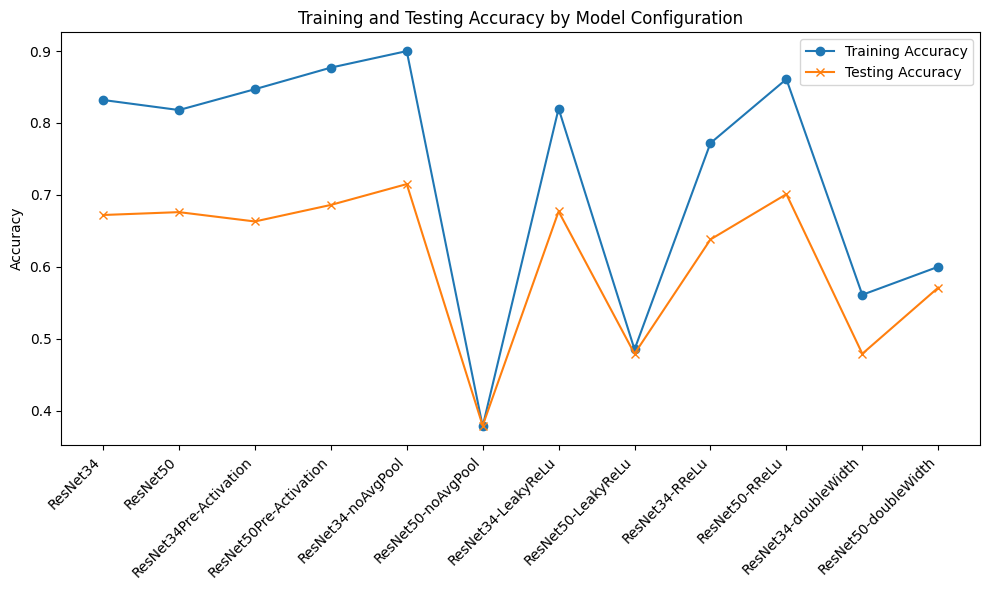

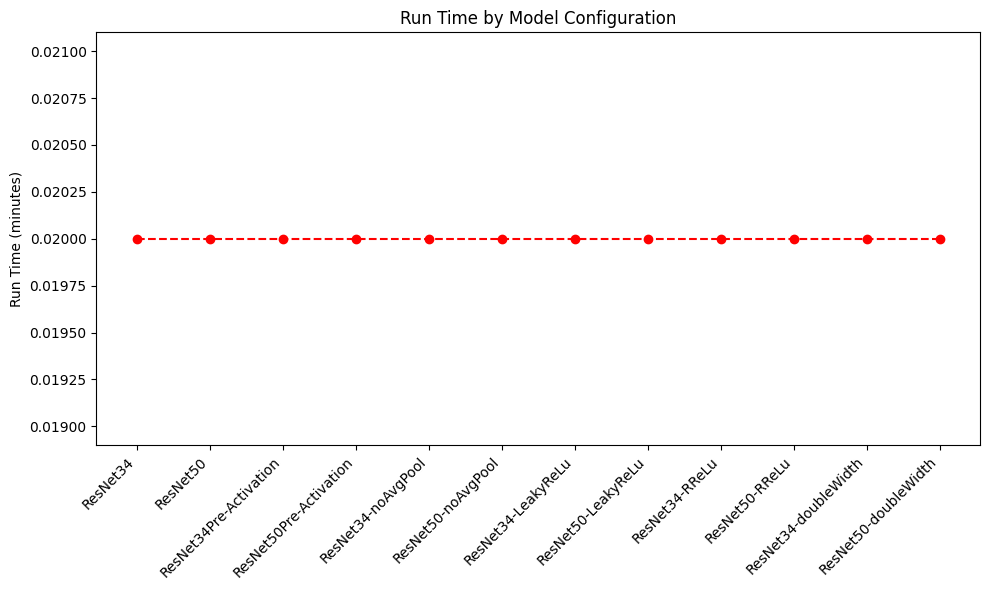

In [37]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(model_name))  # the label locations

# Plotting training and testing accuracy
plt.figure(figsize=(10, 6))
plt.plot(x, training_accuracy, label='Training Accuracy', marker='o')
plt.plot(x, testing_accuracy, label='Testing Accuracy', marker='x')

# Adding labels and title
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy by Model Configuration')
plt.xticks(x, model_name, rotation=45, ha="right")
plt.legend()

plt.tight_layout()
plt.show()

# Plotting run time
plt.figure(figsize=(10, 6))
plt.plot(x, run_time, label='Run Time', marker='o', linestyle='--', color='r')

# Adding labels and title
plt.ylabel('Run Time (minutes)')
plt.title('Run Time by Model Configuration')
plt.xticks(x, model_name, rotation=45, ha="right")

plt.tight_layout()
plt.show()